In [1]:
import numpy as np
import copy
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt 
%matplotlib inline 

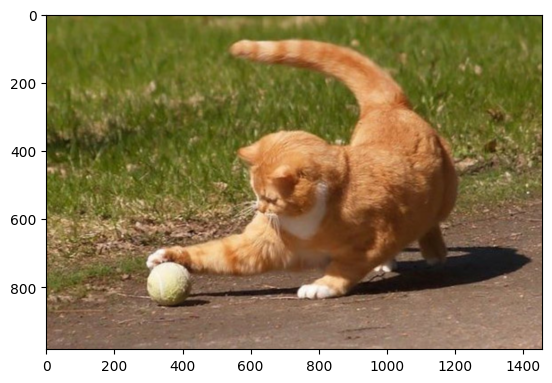

In [793]:
raw_img = cv2.imread("clustering.png", cv2.IMREAD_COLOR)
# examples below were run at full resolution
# originally used to shrink imgs during the dev process to save on runtime
# no effect currently
h = int(raw_img.shape[0])
w = int(raw_img.shape[1])
resized = cv2.resize(raw_img, (w, h), interpolation = cv2.INTER_AREA)
img = resized.astype(np.float32) / 255.
img_rgb = img[...,::-1]
plt.imshow(img_rgb)

### K-means Color Only

In [798]:
# given labels of an image
# construct new image colored by centroids
def recolor_img(centroids, label):
    recolored_img = np.zeros(img_rgb.shape)
    for i in range(img_rgb.shape[0]):
        for j in range(img_rgb.shape[1]):
            label = int(labels[i, j])
            recolored_img[i, j, :] = centroids[label, :]
    return recolored_img

In [819]:
def my_kmeans_rgb(I, k):
    max_iter = 100
    tol = 1e-6
    
    # init means by choosing a random pixels of the input image
    # randomly picks the indicies
    means_gen_h = np.random.randint(I.shape[0],size=k).reshape(k,1)
    means_gen_w = np.random.randint(I.shape[1],size=k).reshape(k,1)

    means = np.zeros([k,3])
            
    for c in range(k):
        means[c,:] = I[means_gen_h[c], means_gen_w[c], :]
    
    # stores the labels of each pixel
    l_data = np.zeros([I.shape[0],I.shape[1]])
    
    itr = 0
    while itr < max_iter:
        # accumulators
        # cur_m_count counters the number of pixels belonging to each centroid
        # cur_means_sum sums up the rgb values of all pixels of each label
        cur_m_count = np.zeros([means.shape[0],1])
        cur_means_sum = np.zeros(means.shape)
        # stores the distance of each pixel to each centroid
        temp_scores = np.zeros([I.shape[0], I.shape[1], k])
        
        for cl in range(k):
            # L2 distance used to compute the diff between a pixel and a centorid
            temp_scores[:,:,cl] = np.linalg.norm(I - means[cl], axis=2)
        # assign label with the smallest L2 distance
        l_data = np.argmin(temp_scores, axis=2)
        
        # for each centorid
        for ct in range(k):
            # counts the number of pixels with the given label
            temp_l = np.where(l_data == ct, 1, 0)
            cur_m_count[ct] = sum(sum(temp_l))
            # makes the 2D mask 3D by stack them along rgb
            mask = np.dstack((temp_l,temp_l,temp_l))
            # mask the img, sums along width and height of image, to get total sumed rgb values
            cur_means_sum[ct, :] = np.sum(np.sum(I*mask, axis=1), axis=0)
        
        # compute mean
        new_means = cur_means_sum / cur_m_count
        
        if np.all(abs(means - new_means) <= tol):
            break
        else:
            means = new_means
            itr += 1
                            
    clusters = means
    L = l_data
    #print('iterations:', itr)
    
    return clusters, L

In [782]:
centroids, labels = my_kmeans_rgb(img_rgb, 4)

iterations: 30


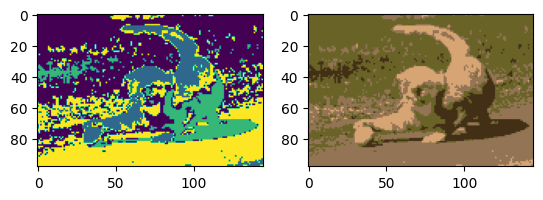

In [783]:
recolored_img = recolor_img(centroids, labels)
plt.subplot(1, 2, 1)
plt.imshow(labels)
plt.subplot(1, 2, 2)
plt.imshow(recolored_img)

### K-means color and position

In [14]:
def my_kmeans_rgb_pos(I, k):
    max_iter = 100
    tol = 1e-6
    
    # init means by choosing a random pixels of the input image
    means_gen_h = np.random.randint(I.shape[0],size=k).reshape(k,1)
    means_gen_w = np.random.randint(I.shape[1],size=k).reshape(k,1)

    means = np.zeros([k,3])
    pos = np.zeros([k,2])
                
    for c in range(k):
        means[c,:] = I[means_gen_h[c], means_gen_w[c], :]
        pos[c, 0] = means_gen_h[c]
        pos[c, 1] = means_gen_w[c]

    # stores the labels of each pixel
    l_data = np.zeros([I.shape[0],I.shape[1]])
    
    # generate row and column indicies of the shape of the input image
    I_coords = np.indices((I.shape[0], I.shape[1]))
    # stacks the indicies where one layer is the row indicies, the next is the column indicies 
    I_coords = np.dstack((I_coords[0],I_coords[1]))
    
    itr = 0
    while itr < max_iter:
        # accumulators
        # cur_m_count counters the number of pixels belonging to each centroid
        # cur_means_sum sums up the rgb values of all pixels of each label
        # cur_pos_sum sums up the combined x and y positions of all pixels of each label
        cur_m_count = np.zeros([means.shape[0],1])
        cur_means_sum = np.zeros(means.shape)
        cur_pos_sum = np.zeros(pos.shape)
        # stores the score of each pixel to each centroid
        temp_scores = np.zeros([I.shape[0], I.shape[1], k])

        for cl in range(k):
            # computes L2 distance of position and color
            color_dist = np.linalg.norm(I - means[cl], axis=2)
            pos_dist = np.linalg.norm(I_coords - pos[cl], axis=2)
            # scales the color distance by how far away the pixels are
            # closer pixels will give smaller score
            temp_scores[:,:,cl] = color_dist * pos_dist
        # assign label with the smallest score
        l_data = np.argmin(temp_scores, axis=2)
        
        # for each centorid
        for ct in range(k):
            temp_l = l_data.copy()
            # counts the number of pixels with the given label
            temp_l = np.where(l_data == ct, 1, 0)
            cur_m_count[ct] = sum(sum(temp_l))
            # makes the nxdx1 mask nxdx3 by stack them along rgb
            mask = np.dstack((temp_l,temp_l,temp_l))
            # mask the img, sums along width and height of image, to get total sumed rgb values
            cur_means_sum[ct, :] = np.sum(np.sum(I*mask, axis=1), axis=0)
            # mask the img, sums along width and height of image, to get total sumed position values
            # since there are 2 dimensions to position, mask is nxdx2
            cur_pos_sum[ct, :] = np.sum(np.sum(I_coords*mask[:,:,0:2], axis=1), axis=0)
        
        # compute and update means
        pos = cur_pos_sum / cur_m_count
        new_means = cur_means_sum / cur_m_count
        
        if np.all(abs(means - new_means) <= tol):
            break
        else:
            means = new_means
            itr += 1
                            
    clusters = means
    L = l_data
    #print('iterations:', itr)
    
    return clusters, L

In [795]:
np.random.seed(0)
centroids, labels = my_kmeans_rgb_pos(img_rgb, 4)

iterations: 62


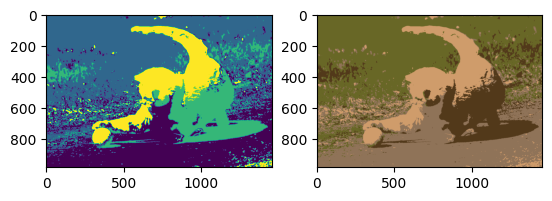

In [799]:
recolored_img = recolor_img(centroids, labels)
plt.subplot(1, 2, 1)
plt.imshow(labels)
plt.subplot(1, 2, 2)
plt.imshow(recolored_img)

### L2 Loss

In [814]:
# assume clustered is the clustered version of the img
# use recolor_img(centroids, label) in section 2.1 to generate clustered version
def L2(img, clustered):
    diff = img - clustered
    diff = diff ** 2.0
    # sum up RGB channels
    loss = np.sum(diff, axis=2) / 3
    # sum up all pixels
    loss = sum(sum(loss)) / (img.shape[0] * img.shape[1])
    return loss

In [821]:
k_s = np.arange(10) + 1
losses = []

for k in k_s:
    np.random.seed(0)
    centroids, labels = my_kmeans_rgb(img_rgb, k)
    recolored_img = recolor_img(centroids, labels)
    loss = L2(img_rgb, recolored_img)
    losses.append(loss)

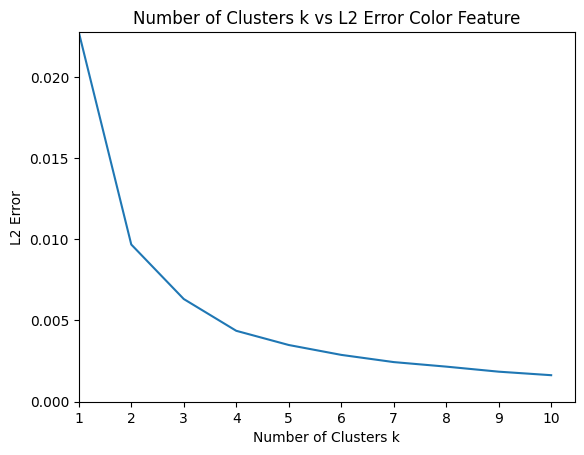

In [843]:
fig,ax = plt.subplots(1)
ax.plot(k_s, losses)
ticks = k_s
ax.set_xticks(k_s)
ax.set_ylim(ymin=0, ymax=max(losses))
ax.set_xlim(xmin=1)
plt.title("Number of Clusters k vs L2 Error Color Feature")
plt.xlabel("Number of Clusters k")
plt.ylabel("L2 Error")
plt.show()

In [841]:
k_s = np.arange(10) + 1
losses_2 = []

for k in k_s:
    np.random.seed(0)
    centroids, labels = my_kmeans_rgb_pos(img_rgb, k)
    recolored_img = recolor_img(centroids, labels)
    loss = L2(img_rgb, recolored_img)
    losses_2.append(loss)

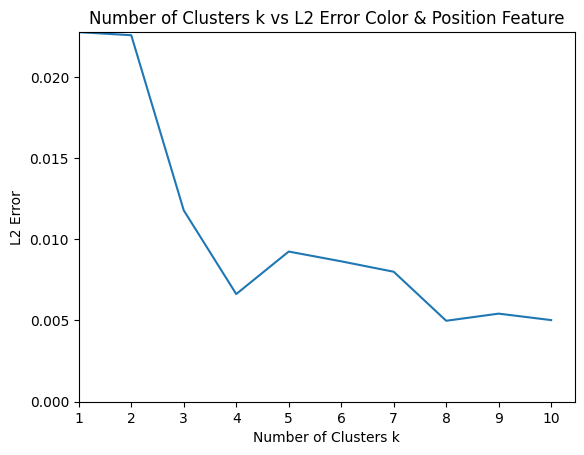

In [844]:
fig,ax = plt.subplots(1)
ax.plot(k_s, losses_2)
ticks = k_s
ax.set_xticks(k_s)
ax.set_ylim(ymin=0, ymax=max(losses_2))
ax.set_xlim(xmin=1)
plt.title("Number of Clusters k vs L2 Error Color & Position Feature")
plt.xlabel("Number of Clusters k")
plt.ylabel("L2 Error")
plt.show()